<a href="https://colab.research.google.com/github/RoyZhaoGA/DroughtForecastAI/blob/main/Classification_Spatial_temporal_graph_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


In [ ]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize

import psutil
import humanize
import os
import GPUtil as GPU

GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize(psutil.virtual_memory().available), " |     Proc size: " + humanize.naturalsize(process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total     {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Preparing metadata (setup.py) ... done
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7393 sha256=348606c9c15f24c7a85bf960fef27fd9449154ef5e988bf7056de8d4c4da4895
  Stored in directory: /root/.cache/pip/wheels/a9/8a/bd/81082387151853ab8b6b3ef33426e98f5cbfebc3c397a9d4d0
Successfully built gputil
Gen RAM Free: 87.7 GB  |     Proc size: 98.3 MB
GPU RAM Free: 40511MB | Used: 2MB | Util   0% | Total     40960MB


In [2]:
!pip install lightning torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 22.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 66.7 MB/s eta 0:00:00


In [64]:
!pip install torch --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 63.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 58.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [1]:
CHECKPOINT_PATH

NameError: ignored

In [3]:
# Standard libraries
import os

# For downloading pre-trained models
import urllib.request
from urllib.error import HTTPError

# PyTorch Lightning
import lightning as L

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# PyTorch geometric
import torch_geometric
import torch_geometric.data as geom_data
import torch_geometric.nn as geom_nn

# PL callbacks
from lightning.pytorch.callbacks import ModelCheckpoint
from torch import Tensor

AVAIL_GPUS = min(1, torch.cuda.device_count())
BATCH_SIZE = 256 if AVAIL_GPUS else 64
# Path to the folder where the datasets are/should be downloaded
DATASET_PATH = os.environ.get("PATH_DATASETS", "data/")
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "/content/drive/MyDrive/DroughtCastAI/Dataset/GNNs"

# Setting the seed
L.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


Import Graph

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import pickle
Graph = pickle.load(open('/content/drive/MyDrive/DroughtCastAI/Dataset/Spatial_temporal_grpah_version_2_classification_0to8.pickle', 'rb'))




In [4]:
Graph

In [5]:
len(Graph.nodes)

83580

In [6]:
len(Graph.nodes[36986])

25

In [197]:
def normalize2(x):
    x_normed = x / x.max(0, keepdim=False)[0]
    return x_normed

**Convert Graph into pytorch geometric dataset**

In [213]:
#EDGE INDEX FOR FULL DATASET
# Extract edge list
edge_list = list(Graph.edges())

# Convert edge list to a 2D tensor
edge_index = torch.tensor(edge_list, dtype=torch.long)
edge_index = edge_index.t().contiguous()

# Ensure the tensor shape is [2, num_edges]
edge_index = edge_index.view(2, -1)

#EDGE INDEX FOR SMALL DATASET
# # Extract edge list
# original_edge_list = list(Graph.edges())
# edge_list = []

# for i, node in enumerate(Graph.nodes()):
#   for j, node2 in enumerate(Graph.nodes()):
#     if (node, node2) in Graph.edges():
#       edge_list.append((i,j))

# # Convert edge list to a 2D tensor
# edge_index = torch.tensor(edge_list, dtype=torch.long)
# edge_index = edge_index.t().contiguous()

# # Ensure the tensor shape is [2, num_edges]
# edge_index = edge_index.view(2, -1)

spei01_features = [Graph.nodes[node]['next_month_spei01_classified'] for node in Graph.nodes()]

# Convert to a tensor

y = torch.tensor(spei01_features, dtype=torch.long)

#y = y.type(torch.LongTensor)
import torch
from torch.nn.functional import normalize

print("y",y)
print("after normalization",y)
feature_names = ['Month', 'Lat', 'Lon', 'temperature_2m', 'temperature_2m_min',
                 'temperature_2m_max', 'dewpoint_temperature_2m', 'total_precipitation_sum',
                 'total_precipitation_min', 'total_precipitation_max', 'u_component_of_wind_10m',
                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
                 'next_month_precipitation', 'year', 'month2', "spei01_classified"]

feature_names2 = ['temperature_2m',  'total_precipitation_sum',
                 'u_component_of_wind_10m',
                 'v_component_of_wind_10m', 'surface_net_solar_radiation_sum', 'total_evaporation_sum',
                 'soil_moisture_am', 'soil_moisture_pm', 'NDVI', 'EVI', 'next_month_tempreature',
                 'next_month_precipitation', 'year', 'month2']

# Extract the features for each node
node_features = []
for node in Graph.nodes():
    node_feature_values = [Graph.nodes[node].get(feature, 0) for feature in feature_names2]  # Defaulting missing values to 0
    #print("node value", node_feature_values)
    node_features.append(node_feature_values)



# Convert to a PyTorch tensor
x = torch.tensor(node_features, dtype=torch.float)

print("features",x)
x2=normalize2(x)
print("after normalization features",x2)
x=x2
#train_months = [201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
#201609, 201610, 201611, 201612]
#val_months = [202101,202102,202103, 202104, 202105, 202106, 202107, 202108, 202109,
#202110, 202111, 202112]
#test_months = [202308]

train_months = [201505, 201506, 201507, 201508, 201509, 201510, 201511, 201512,
201601, 201602, 201603, 201604, 201605, 201606, 201607, 201608,
201609, 201610, 201611, 201612, 201701, 201702, 201703, 201704,
201705, 201706, 201707, 201708, 201709, 201710, 201711, 201712,
201801, 201802, 201803, 201804, 201805, 201806, 201807, 201808,
201809, 201810, 201811, 201812, 201901, 201902, 201903, 201904,
201905, 201906, 201907, 201908, 201909, 201910, 201911, 201912,
202001, 202002, 202003, 202004, 202005, 202006, 202007, 202008,
202009, 202010, 202011, 202012, 202101, 202102]
val_months = [202103, 202104, 202105, 202106, 202107, 202108, 202109,
202110, 202111, 202112, 202201, 202202, 202203, 202204, 202205]
#test_months = [202206, 202207, 202208, 202209, 202210, 202211, 202212, 202301, 202302, 202303, 202304, 202305, 202306, 202307, 202308]
test_months = [202303, 202304, 202305, 202306, 202307, 202308]

train_mask_list = []

for node in Graph.nodes():
    is_in_train_months = Graph.nodes[node]['Month'] in train_months
    train_mask_list.append(is_in_train_months)

train_mask = torch.tensor(train_mask_list, dtype=torch.bool)

val_mask_list = []

for node in Graph.nodes():
    is_in_val_months = Graph.nodes[node]['Month'] in val_months

    val_mask_list.append(is_in_val_months)

val_mask = torch.tensor(val_mask_list, dtype=torch.bool)

test_mask_list = []

for node in Graph.nodes():
    is_in_test_months = Graph.nodes[node]['Month'] in test_months

    test_mask_list.append(is_in_test_months)

test_mask = torch.tensor(test_mask_list, dtype=torch.bool)

graph_data = torch_geometric.data.Data(x=x, edge_index=edge_index, y=y, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)

y tensor([3, 0, 1,  ..., 7, 8, 8])
after normalization tensor([3, 0, 1,  ..., 7, 8, 8])
features tensor([[ 2.8861e+02,  2.0975e-02,  3.1162e-01,  ...,  3.5637e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.8660e+02,  1.2716e-02,  8.6133e-01,  ...,  1.7196e-05,
          2.0150e+03,  5.0000e+00],
        [ 2.8766e+02,  1.0376e-02,  1.9722e-01,  ...,  2.3059e-05,
          2.0150e+03,  5.0000e+00],
        ...,
        [ 2.9918e+02,  8.5536e-03, -2.2026e-01,  ...,  2.7431e-05,
          2.0230e+03,  8.0000e+00],
        [ 2.9981e+02,  4.9977e-03, -2.9886e-02,  ...,  2.3114e-05,
          2.0230e+03,  8.0000e+00],
        [ 3.0042e+02,  4.2188e-03,  4.8622e-01,  ...,  1.5411e-05,
          2.0230e+03,  8.0000e+00]])
after normalization features tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  

In [200]:
edge_index

tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]])

In [201]:
y
torch.min(y)
torch.max(y)


tensor(8)

In [202]:
x

tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]])

In [203]:
from torch.utils.data import Dataset, DataLoader

In [204]:
class GraphDataset(Dataset):
    def __init__(self, data):
        self.data = data
        self.num_node_features = data.x.size(1)

    def __len__(self):
        return 1

    def __getitem__(self, idx):
        return graph_data

In [205]:
graph_dataset = GraphDataset(graph_data)



## Graph Neural Networks

In [206]:
gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

In [166]:
global x_tensor

In [214]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """GNNModel.

        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the graph layer (e.g. number of heads for GAT)
        """
        super().__init__()
        gnn_layer = gnn_layer_by_name[layer_name]

        print("Model Initialized")

        print("self:")
        print(self)

        print("c_in:")
        print(c_in)

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            print("layer", l_idx);
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                #nn.ReLU(inplace=True),
                #nn.Linear(10,1),
                nn.Tanh(),
                #nn.LeakyReLU(inplace=True),
                #nn.Sigmoid(),
                #nn.Softmax(dim=1),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden

        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)


    def forward(self, x, edge_index):
        """Forward.

        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        i=0
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            # All PyTorch Geometric graph layer inherit the class "MessagePassing", hence
            # we can simply check the class type.
            print("layer", i);
            i+=1
            print(layer)
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)
            print("----x:")
            print(x)
            print(x.size())
        return x

In [208]:
loss_list = []

In [209]:
class NodeLevelClassificationGNN(L.LightningModule):
    def __init__(self, model_name, **model_kwargs):
        super().__init__()
        # Saving hyperparameters
        self.save_hyperparameters()

        # Initialize the model
        if model_name == "MLP":
            self.model = MLPModel(**model_kwargs)  # Ensure MLPModel outputs continuous values
        else:
            self.model = GNNModel(**model_kwargs)  # Ensure GNNModel outputs continuous values

        # Use CrossEntropy Loss for classification
        self.loss_module = nn.CrossEntropyLoss()

    def forward(self, data, mode="train"):
        # print("Data:")

        x, edge_index = data.x, data.edge_index

        print("Before model x:")
        print(x)
        print("edge_index:")
        print(edge_index)
        x = self.model(x, edge_index)
        print("x:")
        print(x)
        global x_tensor
        x_tensor = x
        global y_tensor
        y_tensor = data.y
        print(x_tensor)
        print(x_tensor.size())
        print("y:")
        print(data.y)

        # Only calculate the loss on the nodes corresponding to the mask
        if mode == "train":
            mask = data.train_mask
        elif mode == "val":
            mask = data.val_mask
        elif mode == "test":
            mask = data.test_mask
        else:
            raise ValueError(f"Unknown forward mode: {mode}")


        print("!!!!model", mode);
        print("!!!x value:", x[mask]);
        print("!!!x size:", x[mask].size());
        print("!!!y value:", data.y[mask]);
        print("!!!y size:", data.y[mask].size());
        global xx
        xx = x[mask]
        global yy
        yy = data.y[mask]
        loss = self.loss_module(x[mask], data.y[mask])
        print("loss:")
        print(loss)
        print(">>>>> X result:",x[mask].argmax(dim=-1) )
        print(">>>>> Y result:",data.y[mask])
        acc = (x[mask].argmax(dim=-1) == data.y[mask]).sum().float() / mask.sum()
        print("acc:")
        print(acc)
        return loss, acc

    def configure_optimizers(self):
        # Optimizer can be adjusted as needed
        optimizer = optim.SGD(self.parameters(), lr=0.1, momentum=0.9, weight_decay=2e-3)
        return optimizer

    def training_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="train")
        loss_list.append(loss.item())
        self.log("train_loss", loss)
        self.log("train_acc", acc)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, acc = self.forward(batch, mode="val")
        self.log("val_acc", acc)

        self.log("val_loss", loss)

    def test_step(self, batch, batch_idx):
        loss,acc  = self.forward(batch, mode="test")
        self.log("test_acc", acc)
        self.log("test_loss", loss)

In [210]:
def train_node_classifier(model_name, dataset, **model_kwargs):
    L.seed_everything(42)
    node_data_loader = geom_data.DataLoader(dataset, batch_size=1)

    # Create a PyTorch Lightning trainer
    root_dir = os.path.join(CHECKPOINT_PATH, "NodeLevelRegression" + model_name)
    os.makedirs(root_dir, exist_ok=True)
    trainer = L.Trainer(
        default_root_dir=root_dir,
        callbacks=[ModelCheckpoint(save_weights_only=True, mode="max", monitor="val_acc")],
        accelerator="auto",
        devices=AVAIL_GPUS,
        max_epochs=100,
        enable_progress_bar=True
    )


    pretrained_filename = "bruh"
    #os.path.join(CHECKPOINT_PATH, "NodeLevelRegression%s.ckpt" % model_name)
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = NodeLevelClassificationGNN.load_from_checkpoint(pretrained_filename)
    else:
        L.seed_everything()
        # Ensure the model's output layer and loss are suitable for regression
        model = NodeLevelClassificationGNN(
            model_name=model_name, c_in=dataset.num_node_features, c_out=9, **model_kwargs
        )
        trainer.fit(model, node_data_loader, node_data_loader)
        model = NodeLevelClassificationGNN.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)



    print("TEST the BEST MoDEL on TEST SET")
    # Test the best model on the test set
    test_result = trainer.test(model, dataloaders=node_data_loader, verbose=True)
    print("!!!!test Result", test_result)
    print("!!!!!!!!!!!!!!!!!!!")
    batch = next(iter(node_data_loader))
    batch = batch.to(model.device)
    train_loss,train_acc = model.forward(batch, mode="train")
    val_loss,val_acc = model.forward(batch, mode="val")
    result = {"train_loss": train_loss, "val_loss": val_loss, "test_loss": test_result[0]["test_loss"],"train": train_acc, "val": val_acc,"test": test_result[0]["test_acc"]}
    return model, result




In [211]:
# Small function for printing the test scores
def print_results(result_dict):
    if "train_loss" in result_dict:
        print("Train loss: " + str(result_dict["train_loss"]))
    if "val_loss" in result_dict:
        print("Val loss: " + str(result_dict["val_loss"]))
    if "test_loss" in result_dict:
        print("Test loss: " + str(result_dict["test_loss"]))

    if "train" in result_dict:
        print("Train accuracy: %4.2f%%" % (100.0 * result_dict["train"]))
    if "val" in result_dict:
        print("Val accuracy:   %4.2f%%" % (100.0 * result_dict["val"]))
    if "test" in result_dict:
        print("Test accuracy:   %4.2f%%" % (100.0 * result_dict["test"]))


In [215]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=graph_dataset, c_hidden=12, num_layers=4, dp_rate=0.1
)

print_results(node_gnn_result)



INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: GPU available: True (cuda), used: True
INFO:lightning.pytorch.utilities.rank_zero:GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: IPU available: False, using: 0 IPUs
INFO:lightning.pytorch.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name        | Type             | Params
-------------------------------------------------
0 | model       | GNNModel         | 609   
1 | loss_module | CrossEntropyLoss | 0     
----------------------------------

Model Initialized
self:
GNNModel()
c_in:
14
layer 0
layer 1
layer 2


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.8315, -11.6627, -25.5241,  ..., -22.4390,  26.5944, -66.9187],
        [-11.1749,  -7.7688, -17.4752,  ..., -15.4065,  17.8414, -45.3090],
        [-10.1274,  -7.0606, -16.0860,  ..., -14.1735,  16.2444, -41.4950],
        ...,
        [ -9.5856,  -6.8132, -15.6349,  ..., -13.6414,  15.4481, -40.3348],
        [ -8.8929,  -6.3493, -14

Training: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.8315, -11.6627, -25.5241,  ..., -22.4390,  26.5944, -66.9187],
        [-11.1749,  -7.7688, -17.4752,  ..., -15.4065,  17.8414, -45.3090],
        [-10.1274,  -7.0606, -16.0860,  ..., -14.1735,  16.2444, -41.4950],
        ...,
        [ -9.5856,  -6.8132, -15.6349,  ..., -13.6414,  15.4481, -40.3348],
        [ -8.8929,  -6.3493, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.9613, -11.6833, -25.5104,  ..., -22.4397,  26.5934, -66.9044],
        [-11.2629,  -7.7828, -17.4659,  ..., -15.4069,  17.8408, -45.2993],
        [-10.2081,  -7.0735, -16.0774,  ..., -14.1739,  16.2438, -41.4861],
        ...,
        [ -9.6638,  -6.8257, -15.6266,  ..., -13.6418,  15.4476, -40.3261],
        [ -8.9659,  -6.3609, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.1925, -11.7268, -25.4846,  ..., -22.4405,  26.5955, -66.8772],
        [-11.4198,  -7.8124, -17.4483,  ..., -15.4074,  17.8423, -45.2809],
        [-10.3519,  -7.1006, -16.0613,  ..., -14.1743,  16.2452, -41.4693],
        ...,
        [ -9.8031,  -6.8519, -15.6110,  ..., -13.6423,  15.4491, -40.3098],
        [ -9.0961,  -6.3855, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.4832, -11.7747, -25.4506,  ..., -22.4396,  26.5969, -66.8388],
        [-11.6170,  -7.8449, -17.4252,  ..., -15.4067,  17.8433, -45.2549],
        [-10.5327,  -7.1304, -16.0401,  ..., -14.1736,  16.2463, -41.4454],
        ...,
        [ -9.9782,  -6.8808, -15.5903,  ..., -13.6417,  15.4502, -40.2866],
        [ -9.2597,  -6.4124, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.7710, -11.8026, -25.4135,  ..., -22.4327,  26.5882, -66.7907],
        [-11.8124,  -7.8639, -17.3999,  ..., -15.4018,  17.8376, -45.2223],
        [-10.7118,  -7.1479, -16.0168,  ..., -14.1691,  16.2411, -41.4156],
        ...,
        [-10.1517,  -6.8977, -15.5678,  ..., -13.6374,  15.4454, -40.2576],
        [ -9.4219,  -6.4282, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.9781, -11.7667, -25.3774,  ..., -22.4173,  26.5366, -66.7345],
        [-11.9531,  -7.8396, -17.3753,  ..., -15.3912,  17.8028, -45.1843],
        [-10.8408,  -7.1257, -15.9942,  ..., -14.1594,  16.2093, -41.3807],
        ...,
        [-10.2768,  -6.8763, -15.5459,  ..., -13.6280,  15.4148, -40.2237],
        [ -9.5388,  -6.4082, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-18.0460, -11.6317, -25.3461,  ..., -22.3930,  26.4176, -66.6715],
        [-11.9993,  -7.7482, -17.3539,  ..., -15.3746,  17.7222, -45.1416],
        [-10.8833,  -7.0420, -15.9746,  ..., -14.1440,  16.1356, -41.3417],
        ...,
        [-10.3182,  -6.7953, -15.5268,  ..., -13.6132,  15.3437, -40.1857],
        [ -9.5775,  -6.3326, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.9533, -11.3954, -25.3191,  ..., -22.3623,  26.2199, -66.6025],
        [-11.9367,  -7.5882, -17.3354,  ..., -15.3535,  17.5883, -45.0949],
        [-10.8260,  -6.8954, -15.9576,  ..., -14.1246,  16.0130, -41.2989],
        ...,
        [-10.2629,  -6.6534, -15.5103,  ..., -13.5945,  15.2253, -40.1442],
        [ -9.5259,  -6.2000, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.7248, -11.0910, -25.2939,  ..., -22.3313,  25.9601, -66.5279],
        [-11.7820,  -7.3820, -17.3181,  ..., -15.3322,  17.4123, -45.0444],
        [-10.6844,  -6.7065, -15.9417,  ..., -14.1050,  15.8517, -41.2527],
        ...,
        [-10.1261,  -6.4706, -15.4948,  ..., -13.5756,  15.0696, -40.0992],
        [ -9.3982,  -6.0293, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.4071, -10.7602, -25.2700,  ..., -22.2980,  25.6662, -66.4477],
        [-11.5668,  -7.1578, -17.3017,  ..., -15.3093,  17.2131, -44.9901],
        [-10.4874,  -6.5012, -15.9265,  ..., -14.0840,  15.6693, -41.2029],
        ...,
        [ -9.9356,  -6.2718, -15.4801,  ..., -13.5554,  14.8933, -40.0509],
        [ -9.2203,  -5.8436, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-17.0607, -10.4423, -25.2444,  ..., -22.2646,  25.3615, -66.3621],
        [-11.3323,  -6.9425, -17.2842,  ..., -15.2864,  17.0067, -44.9322],
        [-10.2725,  -6.3040, -15.9104,  ..., -14.0629,  15.4803, -41.1499],
        ...,
        [ -9.7279,  -6.0809, -15.4644,  ..., -13.5350,  14.7106, -39.9993],
        [ -9.0263,  -5.6653, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.7373, -10.1617, -25.2155,  ..., -22.2305,  25.0686, -66.2716],
        [-11.1133,  -6.7524, -17.2644,  ..., -15.2630,  16.8083, -44.8709],
        [-10.0720,  -6.1299, -15.8921,  ..., -14.0413,  15.2985, -41.0937],
        ...,
        [ -9.5341,  -5.9124, -15.4466,  ..., -13.5143,  14.5351, -39.9447],
        [ -8.8453,  -5.5079, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.4774,  -9.9229, -25.1830,  ..., -22.1938,  24.8035, -66.1768],
        [-10.9374,  -6.5907, -17.2422,  ..., -15.2378,  16.6287, -44.8067],
        [ -9.9110,  -5.9818, -15.8717,  ..., -14.0182,  15.1341, -41.0350],
        ...,
        [ -9.3785,  -5.7691, -15.4267,  ..., -13.4919,  14.3763, -39.8876],
        [ -8.7001,  -5.3741, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.3032,  -9.7187, -25.1485,  ..., -22.1483,  24.5730, -66.0784],
        [-10.8196,  -6.4525, -17.2185,  ..., -15.2066,  16.4727, -44.7400],
        [ -9.8032,  -5.8552, -15.8499,  ..., -13.9895,  14.9913, -40.9739],
        ...,
        [ -9.2745,  -5.6466, -15.4056,  ..., -13.4643,  14.2385, -39.8283],
        [ -8.6030,  -5.2596, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.2204,  -9.5353, -25.1132,  ..., -22.0924,  24.3761, -65.9767],
        [-10.7638,  -6.3283, -17.1943,  ..., -15.1683,  16.3394, -44.6712],
        [ -9.7523,  -5.7415, -15.8277,  ..., -13.9543,  14.8693, -40.9109],
        ...,
        [ -9.2255,  -5.5366, -15.3839,  ..., -13.4303,  14.1208, -39.7670],
        [ -8.5574,  -5.1569, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.2228,  -9.3610, -25.0778,  ..., -22.0245,  24.2132, -65.8724],
        [-10.7659,  -6.2103, -17.1701,  ..., -15.1219,  16.2292, -44.6006],
        [ -9.7543,  -5.6335, -15.8054,  ..., -13.9116,  14.7685, -40.8462],
        ...,
        [ -9.2278,  -5.4320, -15.3623,  ..., -13.3892,  14.0237, -39.7041],
        [ -8.5596,  -5.0592, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.2819,  -9.1941, -25.0436,  ..., -21.9467,  24.0789, -65.7656],
        [-10.8063,  -6.0973, -17.1467,  ..., -15.0688,  16.1385, -44.5283],
        [ -9.7916,  -5.5300, -15.7838,  ..., -13.8628,  14.6855, -40.7800],
        ...,
        [ -9.2643,  -5.3319, -15.3412,  ..., -13.3420,  13.9438, -39.6398],
        [ -8.5938,  -4.9657, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.3745,  -9.0233, -25.0114,  ..., -21.8599,  23.9653, -65.6567],
        [-10.8695,  -5.9817, -17.1246,  ..., -15.0095,  16.0618, -44.4546],
        [ -9.8496,  -5.4241, -15.7634,  ..., -13.8084,  14.6154, -40.7125],
        ...,
        [ -9.3208,  -5.2294, -15.3214,  ..., -13.2895,  13.8764, -39.5741],
        [ -8.6467,  -4.8700, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.4692,  -8.8465, -24.9813,  ..., -21.7686,  23.8620, -65.5457],
        [-10.9341,  -5.8621, -17.1039,  ..., -14.9471,  15.9921, -44.3794],
        [ -9.9091,  -5.3146, -15.7444,  ..., -13.7511,  14.5517, -40.6437],
        ...,
        [ -9.3788,  -5.1234, -15.3029,  ..., -13.2341,  13.8152, -39.5072],
        [ -8.7009,  -4.7710, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.5456,  -8.6580, -24.9527,  ..., -21.6761,  23.7533, -65.4327],
        [-10.9864,  -5.7345, -17.0843,  ..., -14.8840,  15.9187, -44.3029],
        [ -9.9572,  -5.1977, -15.7263,  ..., -13.6931,  14.4847, -40.5736],
        ...,
        [ -9.4257,  -5.0103, -15.2853,  ..., -13.1781,  13.7508, -39.4391],
        [ -8.7449,  -4.6654, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.5857,  -8.4477, -24.9253,  ..., -21.5857,  23.6273, -65.3180],
        [-11.0140,  -5.5921, -17.0655,  ..., -14.8223,  15.8337, -44.2252],
        [ -9.9826,  -5.0674, -15.7089,  ..., -13.6364,  14.4069, -40.5024],
        ...,
        [ -9.4507,  -4.8842, -15.2684,  ..., -13.1234,  13.6760, -39.3699],
        [ -8.7684,  -4.5476, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.5770,  -8.2121, -24.8972,  ..., -21.5027,  23.4770, -65.2016],
        [-11.0085,  -5.4326, -17.0462,  ..., -14.7656,  15.7320, -44.1465],
        [ -9.9779,  -4.9213, -15.6911,  ..., -13.5843,  14.3140, -40.4303],
        ...,
        [ -9.4465,  -4.7428, -15.2510,  ..., -13.0731,  13.5865, -39.2998],
        [ -8.7646,  -4.4156, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.5129,  -7.9540, -24.8674,  ..., -21.4307,  23.2946, -65.0839],
        [-10.9655,  -5.2579, -17.0257,  ..., -14.7163,  15.6087, -44.0668],
        [ -9.9386,  -4.7613, -15.6722,  ..., -13.5391,  14.2011, -40.3573],
        ...,
        [ -9.4089,  -4.5880, -15.2326,  ..., -13.0294,  13.4778, -39.2289],
        [ -8.7296,  -4.2709, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.3962,  -7.6855, -24.8357,  ..., -21.3678,  23.0865, -64.9650],
        [-10.8868,  -5.0761, -17.0039,  ..., -14.6733,  15.4679, -43.9862],
        [ -9.8668,  -4.5949, -15.6522,  ..., -13.4995,  14.0723, -40.2836],
        ...,
        [ -9.3397,  -4.4269, -15.2131,  ..., -12.9912,  13.3536, -39.1572],
        [ -8.6650,  -4.1205, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.2376,  -7.4192, -24.8021,  ..., -21.3138,  22.8686, -64.8449],
        [-10.7797,  -4.8959, -16.9809,  ..., -14.6362,  15.3205, -43.9049],
        [ -9.7688,  -4.4298, -15.6309,  ..., -13.4654,  13.9374, -40.2091],
        ...,
        [ -9.2453,  -4.2672, -15.1925,  ..., -12.9584,  13.2235, -39.0848],
        [ -8.5770,  -3.9713, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.0471,  -7.1779, -24.7662,  ..., -21.2679,  22.6537, -64.7238],
        [-10.6510,  -4.7325, -16.9563,  ..., -14.6047,  15.1751, -43.8229],
        [ -9.6511,  -4.2802, -15.6082,  ..., -13.4364,  13.8043, -40.1340],
        ...,
        [ -9.1317,  -4.1224, -15.1704,  ..., -12.9304,  13.0952, -39.0118],
        [ -8.4709,  -3.8361, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.8401,  -6.9704, -24.7296,  ..., -21.2240,  22.4501, -64.6020],
        [-10.5111,  -4.5921, -16.9312,  ..., -14.5745,  15.0374, -43.7404],
        [ -9.5231,  -4.1517, -15.5851,  ..., -13.4086,  13.6783, -40.0585],
        ...,
        [ -9.0082,  -3.9980, -15.1479,  ..., -12.9037,  12.9738, -38.9384],
        [ -8.3557,  -3.7199, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.6291,  -6.8068, -24.6928,  ..., -21.1794,  22.2723, -64.4795],
        [-10.3685,  -4.4815, -16.9059,  ..., -14.5438,  14.9172, -43.6576],
        [ -9.3926,  -4.0505, -15.5619,  ..., -13.3804,  13.5684, -39.9826],
        ...,
        [ -8.8823,  -3.9001, -15.1253,  ..., -12.8765,  12.8679, -38.8646],
        [ -8.2382,  -3.6285, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.4279,  -6.6807, -24.6577,  ..., -21.1268,  22.1269, -64.3565],
        [-10.2325,  -4.3962, -16.8819,  ..., -14.5078,  14.8190, -43.5743],
        [ -9.2682,  -3.9725, -15.5397,  ..., -13.3472,  13.4786, -39.9063],
        ...,
        [ -8.7623,  -3.8246, -15.1037,  ..., -12.8445,  12.7815, -38.7905],
        [ -8.1262,  -3.5580, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.2454,  -6.5861, -24.6256,  ..., -21.0642,  22.0126, -64.2330],
        [-10.1092,  -4.3323, -16.8598,  ..., -14.4649,  14.7418, -43.4907],
        [ -9.1554,  -3.9140, -15.5194,  ..., -13.3078,  13.4081, -39.8297],
        ...,
        [ -8.6535,  -3.7680, -15.0839,  ..., -12.8065,  12.7137, -38.7160],
        [ -8.0247,  -3.5052, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.0877,  -6.5120, -24.5961,  ..., -20.9919,  21.9249, -64.1092],
        [-10.0028,  -4.2823, -16.8395,  ..., -14.4154,  14.6828, -43.4068],
        [ -9.0581,  -3.8682, -15.5007,  ..., -13.2623,  13.3542, -39.7529],
        ...,
        [ -8.5597,  -3.7238, -15.0657,  ..., -12.7626,  12.6621, -38.6414],
        [ -7.9372,  -3.4639, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.9493,  -6.4462, -24.5694,  ..., -20.9104,  21.8555, -63.9851],
        [ -9.9094,  -4.2380, -16.8212,  ..., -14.3597,  14.6361, -43.3228],
        [ -8.9728,  -3.8277, -15.4838,  ..., -13.2111,  13.3117, -39.6760],
        ...,
        [ -8.4775,  -3.6846, -15.0492,  ..., -12.7132,  12.6215, -38.5666],
        [ -7.8605,  -3.4273, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.8217,  -6.3753, -24.5445,  ..., -20.8230,  21.7927, -63.8607],
        [ -9.8233,  -4.1901, -16.8040,  ..., -14.3000,  14.5940, -43.2386],
        [ -8.8941,  -3.7840, -15.4679,  ..., -13.1563,  13.2732, -39.5988],
        ...,
        [ -8.4017,  -3.6423, -15.0337,  ..., -12.6602,  12.5848, -38.4916],
        [ -7.7898,  -3.3878, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.6913,  -6.2977, -24.5202,  ..., -20.7350,  21.7297, -63.7361],
        [ -9.7354,  -4.1377, -16.7872,  ..., -14.2399,  14.5517, -43.1542],
        [ -8.8138,  -3.7361, -15.4524,  ..., -13.1010,  13.2347, -39.5216],
        ...,
        [ -8.3244,  -3.5960, -15.0186,  ..., -12.6069,  12.5480, -38.4165],
        [ -7.7177,  -3.3446, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.5582,  -6.2053, -24.4946,  ..., -20.6505,  21.6582, -63.6115],
        [ -9.6456,  -4.0753, -16.7696,  ..., -14.1821,  14.5036, -43.0699],
        [ -8.7317,  -3.6790, -15.4361,  ..., -13.0479,  13.1909, -39.4443],
        ...,
        [ -8.2453,  -3.5408, -15.0027,  ..., -12.5556,  12.5062, -38.3414],
        [ -7.6440,  -3.2930, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.4091,  -6.0923, -24.4666,  ..., -20.5743,  21.5717, -63.4868],
        [ -9.5450,  -3.9990, -16.7504,  ..., -14.1300,  14.4454, -42.9854],
        [ -8.6397,  -3.6092, -15.4184,  ..., -13.0000,  13.1377, -39.3670],
        ...,
        [ -8.1567,  -3.4732, -14.9854,  ..., -12.5094,  12.4552, -38.2662],
        [ -7.5613,  -3.2300, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.2411,  -5.9598, -24.4370,  ..., -20.5042,  21.4716, -63.3622],
        [ -9.4315,  -3.9095, -16.7300,  ..., -14.0820,  14.3779, -42.9011],
        [ -8.5360,  -3.5273, -15.3996,  ..., -12.9559,  13.0762, -39.2898],
        ...,
        [ -8.0567,  -3.3940, -14.9671,  ..., -12.4669,  12.3962, -38.1911],
        [ -7.4680,  -3.1560, -14

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-14.0547,  -5.8162, -24.4058,  ..., -20.4406,  21.3629, -63.2377],
        [ -9.3056,  -3.8124, -16.7086,  ..., -14.0384,  14.3046, -42.8168],
        [ -8.4208,  -3.4385, -15.3799,  ..., -12.9158,  13.0092, -39.2126],
        ...,
        [ -7.9456,  -3.3081, -14.9479,  ..., -12.4282,  12.3319, -38.1161],
        [ -7.3644,  -3.0757, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-13.8485,  -5.6612, -24.3727,  ..., -20.3842,  21.2453, -63.1132],
        [ -9.1663,  -3.7077, -16.6859,  ..., -13.9998,  14.2253, -42.7324],
        [ -8.2934,  -3.3426, -15.3589,  ..., -12.8803,  12.9367, -39.1353],
        ...,
        [ -7.8226,  -3.2153, -14.9275,  ..., -12.3940,  12.2622, -38.0410],
        [ -7.2496,  -2.9891, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-13.6321,  -5.4920, -24.3382,  ..., -20.3311,  21.1224, -62.9887],
        [ -9.0201,  -3.5933, -16.6622,  ..., -13.9633,  14.1423, -42.6482],
        [ -8.1596,  -3.2379, -15.3371,  ..., -12.8468,  12.8609, -39.0582],
        ...,
        [ -7.6936,  -3.1140, -14.9063,  ..., -12.3617,  12.1894, -37.9660],
        [ -7.1291,  -2.8945, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-13.4143,  -5.3046, -24.3040,  ..., -20.2797,  20.9982, -62.8643],
        [ -8.8729,  -3.4666, -16.6387,  ..., -13.9281,  14.0585, -42.5640],
        [ -8.0250,  -3.1220, -15.3155,  ..., -12.8143,  12.7843, -38.9810],
        ...,
        [ -7.5636,  -3.0019, -14.8852,  ..., -12.3304,  12.1158, -37.8910],
        [ -7.0079,  -2.7898, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-13.1976,  -5.0914, -24.2697,  ..., -20.2285,  20.8747, -62.7400],
        [ -8.7264,  -3.3224, -16.6152,  ..., -13.8929,  13.9752, -42.4798],
        [ -7.8910,  -2.9900, -15.2938,  ..., -12.7820,  12.7081, -38.9040],
        ...,
        [ -7.4343,  -2.8742, -14.8641,  ..., -12.2992,  12.0425, -37.8161],
        [ -6.8872,  -2.6706, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.9915,  -4.8471, -24.2357,  ..., -20.1760,  20.7501, -62.6159],
        [ -8.5871,  -3.1571, -16.5918,  ..., -13.8568,  13.8910, -42.3958],
        [ -7.7636,  -2.8387, -15.2723,  ..., -12.7488,  12.6313, -38.8270],
        ...,
        [ -7.3114,  -2.7278, -14.8432,  ..., -12.2673,  11.9687, -37.7413],
        [ -6.7725,  -2.5339, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.7987,  -4.5673, -24.2027,  ..., -20.1204,  20.6245, -62.4920],
        [ -8.4569,  -2.9679, -16.5692,  ..., -13.8187,  13.8063, -42.3119],
        [ -7.6444,  -2.6654, -15.2514,  ..., -12.7138,  12.5538, -38.7502],
        ...,
        [ -7.1965,  -2.5601, -14.8229,  ..., -12.2335,  11.8942, -37.6666],
        [ -6.6653,  -2.3773, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.6198,  -4.2622, -24.1702,  ..., -20.0626,  20.5036, -62.3682],
        [ -8.3361,  -2.7614, -16.5469,  ..., -13.7791,  13.7247, -42.2281],
        [ -7.5340,  -2.4764, -15.2308,  ..., -12.6773,  12.4793, -38.6734],
        ...,
        [ -7.0900,  -2.3772, -14.8028,  ..., -12.1984,  11.8226, -37.5920],
        [ -6.5659,  -2.2065, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.4589,  -3.9225, -24.1384,  ..., -20.0014,  20.3879, -62.2447],
        [ -8.2275,  -2.5316, -16.5251,  ..., -13.7372,  13.6467, -42.1445],
        [ -7.4347,  -2.2660, -15.2107,  ..., -12.6388,  12.4080, -38.5969],
        ...,
        [ -6.9942,  -2.1735, -14.7832,  ..., -12.1612,  11.7541, -37.5176],
        [ -6.4766,  -2.0163, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.3094,  -3.5727, -24.1064,  ..., -19.9389,  20.2793, -62.1213],
        [ -8.1266,  -2.2949, -16.5031,  ..., -13.6944,  13.5734, -42.0609],
        [ -7.3424,  -2.0493, -15.1904,  ..., -12.5994,  12.3410, -38.5204],
        ...,
        [ -6.9054,  -1.9638, -14.7635,  ..., -12.1232,  11.6898, -37.4432],
        [ -6.3937,  -1.8205, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.1724,  -3.2071, -24.0741,  ..., -19.8757,  20.1736, -61.9981],
        [ -8.0342,  -2.0475, -16.4809,  ..., -13.6511,  13.5021, -41.9775],
        [ -7.2580,  -1.8229, -15.1700,  ..., -12.5597,  12.2759, -38.4440],
        ...,
        [ -6.8241,  -1.7447, -14.7436,  ..., -12.0849,  11.6274, -37.3690],
        [ -6.3178,  -1.6158, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.0383,  -2.8700, -24.0411,  ..., -19.8145,  20.0759, -61.8752],
        [ -7.9437,  -1.8194, -16.4582,  ..., -13.6092,  13.4363, -41.8943],
        [ -7.1753,  -1.6141, -15.1491,  ..., -12.5211,  12.2158, -38.3677],
        ...,
        [ -6.7444,  -1.5426, -14.7232,  ..., -12.0477,  11.5697, -37.2948],
        [ -6.2436,  -1.4271, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.8983,  -2.5665, -24.0066,  ..., -19.7569,  19.9809, -61.7523],
        [ -7.8493,  -1.6141, -16.4346,  ..., -13.5697,  13.3722, -41.8111],
        [ -7.0890,  -1.4261, -15.1273,  ..., -12.4848,  12.1573, -38.2916],
        ...,
        [ -6.6613,  -1.3607, -14.7020,  ..., -12.0127,  11.5136, -37.2208],
        [ -6.1660,  -1.2573, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.7484,  -2.3010, -23.9708,  ..., -19.7045,  19.8899, -61.6296],
        [ -7.7481,  -1.4346, -16.4100,  ..., -13.5337,  13.3109, -41.7280],
        [ -6.9965,  -1.2618, -15.1047,  ..., -12.4517,  12.1014, -38.2155],
        ...,
        [ -6.5721,  -1.2017, -14.6800,  ..., -11.9808,  11.4600, -37.1469],
        [ -6.0828,  -1.1088, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.5887,  -2.0461, -23.9344,  ..., -19.6546,  19.8026, -61.5071],
        [ -7.6403,  -1.2622, -16.3850,  ..., -13.4995,  13.2522, -41.6451],
        [ -6.8979,  -1.1040, -15.0817,  ..., -12.4202,  12.0477, -38.1396],
        ...,
        [ -6.4771,  -1.0490, -14.6576,  ..., -11.9505,  11.4086, -37.0730],
        [ -5.9942,  -0.9663, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.4118,  -1.7960, -23.8971,  ..., -19.6085,  19.7165, -61.3848],
        [ -7.5208,  -1.0931, -16.3594,  ..., -13.4678,  13.1942, -41.5623],
        [ -6.7887,  -0.9492, -15.0581,  ..., -12.3911,  11.9948, -38.0637],
        ...,
        [ -6.3718,  -0.8992, -14.6347,  ..., -11.9224,  11.3578, -36.9993],
        [ -5.8959,  -0.8264, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.2220,  -1.4410, -23.8595,  ..., -19.5633,  19.6296, -61.2627],
        [ -7.3927,  -0.8530, -16.3337,  ..., -13.4368,  13.1357, -41.4796],
        [ -6.6715,  -0.7294, -15.0344,  ..., -12.3625,  11.9414, -37.9880],
        ...,
        [ -6.2587,  -0.6865, -14.6116,  ..., -11.8949,  11.3067, -36.9257],
        [ -5.7904,  -0.6277, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-11.0225,  -0.9839, -23.8225,  ..., -19.5175,  19.5416, -61.1408],
        [ -7.2579,  -0.5437, -16.3083,  ..., -13.4053,  13.0763, -41.3971],
        [ -6.5482,  -0.4463, -15.0110,  ..., -12.3335,  11.8872, -37.9124],
        ...,
        [ -6.1397,  -0.4125, -14.5888,  ..., -11.8671,  11.2548, -36.8522],
        [ -5.6794,  -0.3719, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-1.0809e+01, -5.1356e-01, -2.3786e+01,  ..., -1.9473e+01,
          1.9452e+01, -6.1019e+01],
        [-7.1133e+00, -2.2551e-01, -1.6283e+01,  ..., -1.3375e+01,
          1.3016e+01, -4.1315e+01],
        [-6.4160e+00, -1.5495e-01, -1.4988e+01,  ..., -1.2306e+01,
          1.1832e+01, -3.7837e+01],
        ...,
        [-6.0122e+00, -1.30

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-1.0581e+01, -5.1307e-01, -2.3749e+01,  ..., -1.9430e+01,
          1.9364e+01, -6.0897e+01],
        [-6.9597e+00, -2.2530e-01, -1.6258e+01,  ..., -1.3345e+01,
          1.2957e+01, -4.1232e+01],
        [-6.2754e+00, -1.5483e-01, -1.4965e+01,  ..., -1.2278e+01,
          1.1778e+01, -3.7761e+01],
        ...,
        [-5.8765e+00, -1.30

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-10.3442,  -0.6385, -23.7133,  ..., -19.3839,  19.2745, -60.7758],
        [ -6.7994,  -0.3103, -16.2334,  ..., -13.3135,  12.8964, -41.1500],
        [ -6.1288,  -0.2327, -14.9420,  ..., -12.2491,  11.7230, -37.6861],
        ...,
        [ -5.7350,  -0.2059, -14.5217,  ..., -11.7857,  11.0974, -36.6323],
        [ -5.3016,  -0.1790, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-1.0100e+01, -2.4202e-01, -2.3678e+01,  ..., -1.9338e+01,
          1.9180e+01, -6.0655e+01],
        [-6.6344e+00, -4.2037e-02, -1.6210e+01,  ..., -1.3282e+01,
          1.2833e+01, -4.1068e+01],
        [-5.9778e+00,  1.2891e-02, -1.4920e+01,  ..., -1.2220e+01,
          1.1665e+01, -3.7611e+01],
        ...,
        [-5.5892e+00,  3.17

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-9.8482e+00, -3.9064e-01, -2.3644e+01,  ..., -1.9291e+01,
          1.9083e+01, -6.0534e+01],
        [-6.4641e+00, -1.4268e-01, -1.6186e+01,  ..., -1.3250e+01,
          1.2768e+01, -4.0986e+01],
        [-5.8220e+00, -7.9305e-02, -1.4898e+01,  ..., -1.2190e+01,
          1.1605e+01, -3.7536e+01],
        ...,
        [-5.4388e+00, -5.75

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-9.5948e+00, -3.7067e-01, -2.3610e+01,  ..., -1.9242e+01,
          1.8983e+01, -6.0413e+01],
        [-6.2928e+00, -1.2919e-01, -1.6163e+01,  ..., -1.3216e+01,
          1.2700e+01, -4.0904e+01],
        [-5.6652e+00, -6.6973e-02, -1.4877e+01,  ..., -1.2160e+01,
          1.1544e+01, -3.7461e+01],
        ...,
        [-5.2874e+00, -4.55

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-9.3383e+00, -1.5901e-01, -2.3577e+01,  ..., -1.9192e+01,
          1.8880e+01, -6.0293e+01],
        [-6.1194e+00,  1.4063e-02, -1.6140e+01,  ..., -1.3182e+01,
          1.2630e+01, -4.0823e+01],
        [-5.5066e+00,  6.4189e-02, -1.4856e+01,  ..., -1.2128e+01,
          1.1480e+01, -3.7387e+01],
        ...,
        [-5.1342e+00,  8.13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -9.0825,  -0.9369, -23.5440,  ..., -19.1409,  18.7761, -60.1728],
        [ -5.9465,  -0.5124, -16.1172,  ..., -13.1467,  12.5604, -40.7418],
        [ -5.3484,  -0.4179, -14.8349,  ..., -12.0956,  11.4161, -37.3123],
        ...,
        [ -4.9815,  -0.3853, -14.4175,  ..., -11.6379,  10.8029, -36.2688],
        [ -4.5984,  -0.3465, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -8.8278,  -0.7663, -23.5120,  ..., -19.0871,  18.6627, -60.0533],
        [ -5.7743,  -0.3969, -16.0952,  ..., -13.1098,  12.4839, -40.6608],
        [ -5.1908,  -0.3121, -14.8146,  ..., -12.0617,  11.3461, -37.2382],
        ...,
        [ -4.8294,  -0.2829, -14.3977,  ..., -11.6052,  10.7357, -36.1968],
        [ -4.4564,  -0.2508, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-8.5717e+00, -1.8741e-02, -2.3480e+01,  ..., -1.9032e+01,
          1.8546e+01, -5.9934e+01],
        [-5.6012e+00,  1.0915e-01, -1.6074e+01,  ..., -1.3072e+01,
          1.2405e+01, -4.0580e+01],
        [-5.0324e+00,  1.5128e-01, -1.4795e+01,  ..., -1.2027e+01,
          1.1274e+01, -3.7164e+01],
        ...,
        [-4.6764e+00,  1.65

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -8.3079,  -2.2167, -23.4484,  ..., -18.9792,  18.4367, -59.8151],
        [ -5.4229,  -1.3784, -16.0516,  ..., -13.0359,  12.3313, -40.4995],
        [ -4.8692,  -1.2109, -14.7744,  ..., -11.9936,  11.2068, -37.0905],
        ...,
        [ -4.5189,  -1.1528, -14.3586,  ..., -11.5396,  10.6018, -36.0532],
        [ -4.1666,  -1.0631, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -8.0518,  -3.8143, -23.4168,  ..., -18.9239,  18.3197, -59.6963],
        [ -5.2497,  -2.4596, -16.0299,  ..., -12.9980,  12.2524, -40.4191],
        [ -4.7108,  -2.2008, -14.7544,  ..., -11.9588,  11.1346, -37.0168],
        ...,
        [ -4.3659,  -2.1111, -14.3391,  ..., -11.5060,  10.5325, -35.9816],
        [ -4.0239,  -1.9579, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -7.8062,  -5.1015, -23.3854,  ..., -18.8669,  18.1927, -59.5777],
        [ -5.0838,  -3.3306, -16.0084,  ..., -12.9589,  12.1666, -40.3389],
        [ -4.5590,  -2.9985, -14.7345,  ..., -11.9229,  11.0563, -36.9433],
        ...,
        [ -4.2193,  -2.8831, -14.3198,  ..., -11.4714,  10.4571, -35.9102],
        [ -3.8871,  -2.6787, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -7.5682,  -6.1855, -23.3549,  ..., -18.8083,  18.0618, -59.4596],
        [ -4.9229,  -4.0642, -15.9874,  ..., -12.9188,  12.0783, -40.2589],
        [ -4.4118,  -3.6701, -14.7152,  ..., -11.8860,  10.9755, -36.8701],
        ...,
        [ -4.0772,  -3.5332, -14.3009,  ..., -11.4358,  10.3794, -35.8390],
        [ -3.7544,  -3.2858, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -7.3293,  -7.1206, -23.3246,  ..., -18.7496,  17.9284, -59.3418],
        [ -4.7614,  -4.6970, -15.9666,  ..., -12.8786,  11.9882, -40.1792],
        [ -4.2641,  -4.2495, -14.6960,  ..., -11.8490,  10.8931, -36.7971],
        ...,
        [ -3.9347,  -4.0940, -14.2822,  ..., -11.4002,  10.3002, -35.7680],
        [ -3.6214,  -3.8094, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -7.0764,  -7.9413, -23.2945,  ..., -18.6912,  17.7978, -59.2244],
        [ -4.5905,  -5.2523, -15.9459,  ..., -12.8385,  11.8999, -40.0996],
        [ -4.1077,  -4.7580, -14.6769,  ..., -11.8122,  10.8124, -36.7242],
        ...,
        [ -3.7836,  -4.5862, -14.2636,  ..., -11.3647,  10.2226, -35.6972],
        [ -3.4804,  -4.2690, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -6.8097,  -8.6657, -23.2637,  ..., -18.6360,  17.6715, -59.1072],
        [ -4.4102,  -5.7425, -15.9247,  ..., -12.8007,  11.8147, -40.0203],
        [ -3.9427,  -5.2069, -14.6574,  ..., -11.7774,  10.7345, -36.6516],
        ...,
        [ -3.6244,  -5.0207, -14.2447,  ..., -11.3311,  10.1477, -35.6266],
        [ -3.3318,  -4.6747, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -6.5278,  -9.3045, -23.2324,  ..., -18.5813,  17.5488, -58.9904],
        [ -4.2197,  -6.1749, -15.9033,  ..., -12.7632,  11.7318, -39.9412],
        [ -3.7684,  -5.6028, -14.6377,  ..., -11.7430,  10.6588, -36.5792],
        ...,
        [ -3.4560,  -5.4039, -14.2254,  ..., -11.2979,  10.0749, -35.5562],
        [ -3.1746,  -5.0325, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -6.2358,  -9.8684, -23.2002,  ..., -18.5284,  17.4288, -58.8738],
        [ -4.0223,  -6.5565, -15.8812,  ..., -12.7269,  11.6508, -39.8623],
        [ -3.5877,  -5.9522, -14.6173,  ..., -11.7096,  10.5847, -36.5069],
        ...,
        [ -3.2815,  -5.7421, -14.2056,  ..., -11.2658,  10.0037, -35.4859],
        [ -3.0118,  -5.3484, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -5.9358, -10.3624, -23.1685,  ..., -18.4741,  17.3122, -58.7577],
        [ -3.8194,  -6.8908, -15.8594,  ..., -12.6898,  11.5721, -39.7837],
        [ -3.4021,  -6.2584, -14.5972,  ..., -11.6754,  10.5128, -36.4349],
        ...,
        [ -3.1023,  -6.0385, -14.1860,  ..., -11.2328,   9.9346, -35.4159],
        [ -2.8444,  -5.6251, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -5.6442, -10.7910, -23.1369,  ..., -18.4197,  17.1924, -58.6418],
        [ -3.6223,  -7.1809, -15.8377,  ..., -12.6525,  11.4912, -39.7052],
        [ -3.2218,  -6.5240, -14.5772,  ..., -11.6411,  10.4389, -36.3630],
        ...,
        [ -2.9281,  -6.2956, -14.1665,  ..., -11.1998,   9.8636, -35.3460],
        [ -2.6819,  -5.8651, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -5.3616, -11.1569, -23.1063,  ..., -18.3633,  17.0658, -58.5262],
        [ -3.4313,  -7.4286, -15.8167,  ..., -12.6138,  11.4057, -39.6270],
        [ -3.0470,  -6.7508, -14.5579,  ..., -11.6056,  10.3608, -36.2914],
        ...,
        [ -2.7592,  -6.5151, -14.1477,  ..., -11.1655,   9.7884, -35.2764],
        [ -2.5243,  -6.0701, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -5.1012, -11.4660, -23.0763,  ..., -18.3046,  16.9320, -58.4108],
        [ -3.2553,  -7.6377, -15.7961,  ..., -12.5736,  11.3154, -39.5489],
        [ -2.8860,  -6.9424, -14.5388,  ..., -11.5686,  10.2782, -36.2198],
        ...,
        [ -2.6038,  -6.7006, -14.1292,  ..., -11.1299,   9.7090, -35.2068],
        [ -2.3792,  -6.2433, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -4.8613, -11.7215, -23.0464,  ..., -18.2446,  16.7895, -58.2957],
        [ -3.0932,  -7.8107, -15.7755,  ..., -12.5326,  11.2191, -39.4710],
        [ -2.7377,  -7.1007, -14.5199,  ..., -11.5309,  10.1902, -36.1485],
        ...,
        [ -2.4606,  -6.8539, -14.1108,  ..., -11.0935,   9.6243, -35.1375],
        [ -2.2456,  -6.3864, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -4.6330, -11.9287, -23.0175,  ..., -18.1819,  16.6402, -58.1810],
        [ -2.9390,  -7.9509, -15.7557,  ..., -12.4896,  11.1182, -39.3933],
        [ -2.5966,  -7.2291, -14.5016,  ..., -11.4914,  10.0979, -36.0774],
        ...,
        [ -2.3245,  -6.9781, -14.0929,  ..., -11.0554,   9.5355, -35.0683],
        [ -2.1186,  -6.5024, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -4.4095, -12.0954, -22.9893,  ..., -18.1181,  16.4850, -58.0665],
        [ -2.7880,  -8.0637, -15.7362,  ..., -12.4460,  11.0134, -39.3158],
        [ -2.4585,  -7.3324, -14.4837,  ..., -11.4513,  10.0020, -36.0064],
        ...,
        [ -2.1912,  -7.0782, -14.0755,  ..., -11.0167,   9.4431, -34.9993],
        [ -1.9942,  -6.5958, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -4.1684, -12.2258, -22.9618,  ..., -18.0527,  16.3257, -57.9523],
        [ -2.6252,  -8.1519, -15.7174,  ..., -12.4012,  10.9057, -39.2385],
        [ -2.3096,  -7.4132, -14.4663,  ..., -11.4102,   9.9035, -35.9356],
        ...,
        [ -2.0474,  -7.1564, -14.0585,  ..., -10.9770,   9.3483, -34.9305],
        [ -1.8600,  -6.6689, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -3.8886, -12.3270, -22.9336,  ..., -17.9879,  16.1646, -57.8384],
        [ -2.4361,  -8.2205, -15.6980,  ..., -12.3569,  10.7968, -39.1613],
        [ -2.1366,  -7.4760, -14.4483,  ..., -11.3694,   9.8039, -35.8650],
        ...,
        [ -1.8803,  -7.2172, -14.0410,  ..., -10.9378,   9.2524, -34.8618],
        [ -1.7041,  -6.7256, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -3.5621, -12.4022, -22.9055,  ..., -17.9232,  15.9994, -57.7247],
        [ -2.2154,  -8.2713, -15.6787,  ..., -12.3127,  10.6851, -39.0844],
        [ -1.9347,  -7.5226, -14.4306,  ..., -11.3288,   9.7018, -35.7945],
        ...,
        [ -1.6853,  -7.2623, -14.0237,  ..., -10.8986,   9.1540, -34.7933],
        [ -1.5220,  -6.7677, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -3.1659, -12.4537, -22.8778,  ..., -17.8592,  15.8339, -57.6114],
        [ -1.9475,  -8.3062, -15.6596,  ..., -12.2689,  10.5733, -39.0077],
        [ -1.6895,  -7.5545, -14.4130,  ..., -11.2886,   9.5995, -35.7242],
        ...,
        [ -1.4483,  -7.2933, -14.0066,  ..., -10.8597,   9.0555, -34.7250],
        [ -1.3008,  -6.7966, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -2.6833, -12.4818, -22.8507,  ..., -17.7933,  15.6668, -57.4985],
        [ -1.6211,  -8.3253, -15.6410,  ..., -12.2238,  10.4603, -38.9312],
        [ -1.3908,  -7.5720, -14.3958,  ..., -11.2471,   9.4961, -35.6542],
        ...,
        [ -1.1596,  -7.3102, -13.9899,  ..., -10.8198,   8.9559, -34.6570],
        [ -1.0313,  -6.8124, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -2.0568, -12.4894, -22.8237,  ..., -17.7272,  15.4974, -57.3859],
        [ -1.1974,  -8.3304, -15.6224,  ..., -12.1786,  10.3458, -38.8550],
        [ -1.0030,  -7.5768, -14.3787,  ..., -11.2056,   9.3914, -35.5844],
        ...,
        [ -0.7846,  -7.3148, -13.9732,  ..., -10.7797,   8.8550, -34.5891],
        [ -0.6812,  -6.8167, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -1.3051, -12.4768, -22.7973,  ..., -17.6588,  15.3269, -57.2736],
        [ -0.6889,  -8.3219, -15.6043,  ..., -12.1318,  10.2305, -38.7790],
        [ -0.5375,  -7.5690, -14.3619,  ..., -11.1626,   9.2859, -35.5148],
        ...,
        [ -0.3344,  -7.3073, -13.9568,  ..., -10.7382,   8.7535, -34.5214],
        [ -0.2609,  -6.8097, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -0.5391, -12.4455, -22.7714,  ..., -17.5891,  15.1561, -57.1617],
        [ -0.1708,  -8.3008, -15.5864,  ..., -12.0842,  10.1151, -38.7033],
        [ -0.0632,  -7.5496, -14.3455,  ..., -11.1188,   9.1803, -35.4455],
        ...,
        [  0.1243,  -7.2886, -13.9408,  ..., -10.6960,   8.6517, -34.4540],
        [  0.1673,  -6.7922, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -1.5145, -12.3957, -22.7458,  ..., -17.5152,  14.9868, -57.0503],
        [ -0.8313,  -8.2670, -15.5688,  ..., -12.0337,  10.0006, -38.6279],
        [ -0.6682,  -7.5188, -14.3292,  ..., -11.0724,   9.0756, -35.3764],
        ...,
        [ -0.4616,  -7.2588, -13.9249,  ..., -10.6512,   8.5508, -34.3869],
        [ -0.3799,  -6.7644, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -2.0793, -12.3324, -22.7200,  ..., -17.4419,  14.8131, -56.9392],
        [ -1.2139,  -8.2242, -15.5510,  ..., -11.9836,   9.8832, -38.5526],
        [ -1.0187,  -7.4796, -14.3128,  ..., -11.0264,   8.9682, -35.3075],
        ...,
        [ -0.8013,  -7.2209, -13.9090,  ..., -10.6068,   8.4473, -34.3199],
        [ -0.6972,  -6.7289, -13

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -2.1782, -12.2621, -22.6930,  ..., -17.3742,  14.6360, -56.8282],
        [ -1.2811,  -8.1766, -15.5325,  ..., -11.9373,   9.7635, -38.4775],
        [ -1.0804,  -7.4360, -14.2957,  ..., -10.9839,   8.8587, -35.2387],
        ...,
        [ -0.8614,  -7.1787, -13.8923,  ..., -10.5658,   8.3418, -34.2530],
        [ -0.7534,  -6.6896, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -1.8208, -12.1838, -22.6660,  ..., -17.3093,  14.4601, -56.7174],
        [ -1.0395,  -8.1237, -15.5139,  ..., -11.8929,   9.6445, -38.4025],
        [ -0.8592,  -7.3876, -14.2785,  ..., -10.9431,   8.7499, -35.1700],
        ...,
        [ -0.6477,  -7.1319, -13.8756,  ..., -10.5264,   8.2370, -34.1862],
        [ -0.5539,  -6.6458, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -0.9832, -12.0976, -22.6385,  ..., -17.2468,  14.2794, -56.6069],
        [ -0.4728,  -8.0654, -15.4950,  ..., -11.8501,   9.5223, -38.3277],
        [ -0.3404,  -7.3342, -14.2611,  ..., -10.9038,   8.6381, -35.1016],
        ...,
        [ -0.1459,  -7.0803, -13.8586,  ..., -10.4885,   8.1292, -34.1196],
        [ -0.0854,  -6.5976, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ 6.3717e-04, -1.2004e+01, -2.2611e+01,  ..., -1.7185e+01,
          1.4094e+01, -5.6497e+01],
        [ 1.9292e-01, -8.0018e+00, -1.5476e+01,  ..., -1.1808e+01,
          9.3968e+00, -3.8253e+01],
        [ 2.6901e-01, -7.2760e+00, -1.4244e+01,  ..., -1.0865e+01,
          8.5233e+00, -3.5033e+01],
        ...,
        [ 4.4358e-01, -7.02

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -4.7212, -11.9001, -22.5850,  ..., -17.1192,  13.9130, -56.3862],
        [ -3.0031,  -7.9318, -15.4582,  ..., -11.7629,   9.2746, -38.1783],
        [ -2.6577,  -7.2119, -14.2272,  ..., -10.8236,   8.4115, -34.9647],
        ...,
        [ -2.3895,  -6.9619, -13.8256,  ..., -10.4112,   7.9108, -33.9866],
        [ -2.1807,  -6.4871, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[ -8.7970, -11.7956, -22.5574,  ..., -17.0603,  13.7255, -56.2761],
        [ -5.7619,  -7.8611, -15.4392,  ..., -11.7226,   9.1478, -38.1037],
        [ -5.1840,  -7.1473, -14.2097,  ..., -10.7865,   8.2955, -34.8965],
        ...,
        [ -4.8351,  -6.8994, -13.8085,  ..., -10.3754,   7.7990, -33.9202],
        [ -4.4644,  -6.4287, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-12.3927, -11.6875, -22.5284,  ..., -17.0098,  13.5264, -56.1662],
        [ -8.1956,  -7.7880, -15.4194,  ..., -11.6880,   9.0132, -38.0293],
        [ -7.4126,  -7.0804, -14.1913,  ..., -10.7547,   8.1723, -34.8283],
        ...,
        [ -6.9925,  -6.8346, -13.7906,  ..., -10.3448,   7.6803, -33.8540],
        [ -6.4791,  -6.3682, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-15.5799, -11.5820, -22.4979,  ..., -16.9674,  13.3242, -56.0564],
        [-10.3529,  -7.7167, -15.3984,  ..., -11.6589,   8.8764, -37.9550],
        [ -9.3881,  -7.0151, -14.1720,  ..., -10.7280,   8.0472, -34.7603],
        ...,
        [ -8.9050,  -6.7715, -13.7718,  ..., -10.3190,   7.5596, -33.7879],
        [ -8.2650,  -6.3092, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-18.4125, -11.4767, -22.4665,  ..., -16.9325,  13.1192, -55.9469],
        [-12.2701,  -7.6455, -15.3768,  ..., -11.6349,   8.7378, -37.8809],
        [-11.1437,  -6.9499, -14.1522,  ..., -10.7059,   7.9203, -34.6924],
        ...,
        [-10.6046,  -6.7084, -13.7525,  ..., -10.2977,   7.4373, -33.7219],
        [ -9.8521,  -6.2503, -12

Validation: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-20.9354, -11.3683, -22.4352,  ..., -16.9015,  12.9100, -55.8377],
        [-13.9778,  -7.5722, -15.3554,  ..., -11.6135,   8.5963, -37.8069],
        [-12.7075,  -6.8828, -14.1324,  ..., -10.6861,   7.7908, -34.6247],
        ...,
        [-12.1185,  -6.6435, -13.7332,  ..., -10.2788,   7.3124, -33.6560],
        [-11.2659,  -6.1897, -12

INFO: `Trainer.fit` stopped: `max_epochs=100` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


tensor([3, 0, 1,  ..., 7, 8, 8], device='cuda:0')
!!!!model val
!!!x value: tensor([[-1.3741, -1.0686, -0.3944,  ...,  0.6033,  0.3347,  0.4334],
        [-1.3758, -1.0693, -0.3951,  ...,  0.6060,  0.3367,  0.4366],
        [-1.3765, -1.0696, -0.3956,  ...,  0.6072,  0.3377,  0.4379],
        ...,
        [-1.3821, -1.0719, -0.3968,  ...,  0.6176,  0.3445,  0.4492],
        [-1.3824, -1.0718, -0.3974,  ...,  0.6184,  0.3453,  0.4499],
        [-1.3827, -1.0722, -0.3971,  ...,  0.6189,  0.3455,  0.4508]],
       device='cuda:0')
!!!x size: torch.Size([12540, 9])
!!!y value: tensor([7, 7, 7,  ..., 8, 8, 8], device='cuda:0')
!!!y size: torch.Size([12540])
loss:
tensor(2.0014, device='cuda:0')
>>>>> X result: tensor([4, 4, 4,  ..., 4, 4, 4], device='cuda:0')
>>>>> Y result: tensor([7, 7, 7,  ..., 8, 8, 8], device='cuda:0')
acc:
tensor(0.2557, device='cuda:0')


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Model Initialized
self:
GNNModel()
c_in:
14
layer 0
layer 1
layer 2
TEST the BEST MoDEL on TEST SET


Testing: |          | 0/? [00:00<?, ?it/s]

Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]],
       device='cuda:0')
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]], device='cuda:0')
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.9613, -11.6833, -25.5104,  ..., -22.4397,  26.5934, -66.9044],
        [-11.2629,  -7.7828, -17.4659,  ..., -15.4069,  17.8408, -45.2993],
        [-10.2081,  -7.0735, -16.0774,  ..., -14.1739,  16.2438, -41.4861],
        ...,
        [ -9.6638,  -6.8257, -15.6266,  ..., -13.6418,  15.4476, -40.3261],
        [ -8.9659,  -6.3609, -14

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.2113237828016281     │
│         test_loss         │    2.1112911701202393     │
└───────────────────────────┴───────────────────────────┘

!!!!test Result [{'test_acc': 0.2113237828016281, 'test_loss': 2.1112911701202393}]
!!!!!!!!!!!!!!!!!!!
Before model x:
tensor([[ 0.9204,  0.0183,  0.0326,  ...,  0.1064,  0.9960,  0.4167],
        [ 0.9140,  0.0111,  0.0901,  ...,  0.0513,  0.9960,  0.4167],
        [ 0.9174,  0.0090,  0.0206,  ...,  0.0688,  0.9960,  0.4167],
        ...,
        [ 0.9541,  0.0075, -0.0230,  ...,  0.0819,  1.0000,  0.6667],
        [ 0.9561,  0.0044, -0.0031,  ...,  0.0690,  1.0000,  0.6667],
        [ 0.9581,  0.0037,  0.0509,  ...,  0.0460,  1.0000,  0.6667]])
edge_index:
tensor([[36896, 36896, 36896,  ..., 18598, 20498, 22398],
        [36996, 40496, 40596,  ..., 20498, 22398, 24697]])
layer 0
GCNConv(14, 12)
----x:
tensor([[-16.9613, -11.6833, -25.5104,  ..., -22.4397,  26.5934, -66.9044],
        [-11.2629,  -7.7828, -17.4659,  ..., -15.4069,  17.8408, -45.2993],
        [-10.2081,  -7.0735, -16.0774,  ..., -14.1739,  16.2438, -41.4861],
        ...,
        [ -9.6638,  -6.8257, -15.6266,  ..., 

In [ ]:
loss_list = []

In [216]:
loss_list

[37.3093376159668,
 2.1844799518585205,
 2.1697611808776855,
 2.153728485107422,
 2.1369287967681885,
 2.1198763847351074,
 2.1029367446899414,
 2.0866570472717285,
 2.0714001655578613,
 2.0574209690093994,
 2.0449557304382324,
 2.034069061279297,
 2.0248911380767822,
 2.017298698425293,
 2.0112576484680176,
 2.0065314769744873,
 2.002979040145874,
 2.000356674194336,
 1.998461127281189,
 1.997096061706543,
 1.9960647821426392,
 1.9952062368392944,
 1.9944514036178589,
 1.9937412738800049,
 1.993046760559082,
 1.99226975440979,
 1.9915173053741455,
 1.9907363653182983,
 1.9900484085083008,
 1.9893553256988525,
 1.9887820482254028,
 1.988242268562317,
 1.9878312349319458,
 1.9874993562698364,
 1.9872817993164062,
 1.9871174097061157,
 1.98700749874115,
 1.9869416952133179,
 1.9869223833084106,
 1.9869194030761719,
 1.986928939819336,
 1.986933946609497,
 1.9869005680084229,
 1.9868736267089844,
 1.9868221282958984,
 1.9867610931396484,
 1.9867216348648071,
 1.986596941947937,
 1.9865051

In [217]:
import matplotlib.pyplot as plt
import torch

def plot_loss_graph(loss_data):
    """
    Plots the training loss over epochs.

    :param loss_data: List of loss values (as PyTorch tensors).
    """
    # Convert tensor list to a list of Python floats

    # Epochs (assuming each loss value corresponds to an epoch)
    epochs = range(1, len(loss_data) + 1)

    # Creating the plot
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_data, marker='o', color='b', label='Training Loss')

    # Adding titles and labels
    plt.title('Epochs vs Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Display the plot
    plt.show()


In [218]:
len(loss_list)

200

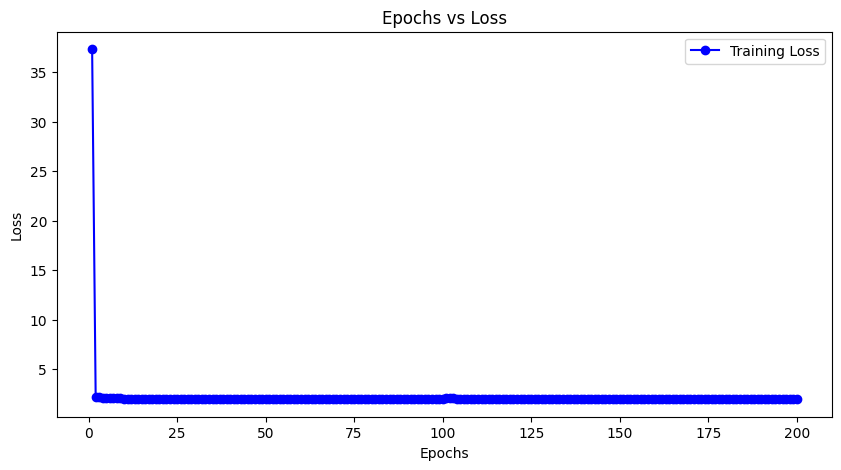

In [219]:
plot_loss_graph(loss_list)

In [ ]:
import torch
print(torch.cuda.is_available())

True


Although the MLP can overfit on the training dataset because of the high-dimensional input features,
it does not perform too well on the test set.
Let's see if we can beat this score with our graph networks:

In [ ]:
node_gnn_model, node_gnn_result = train_node_classifier(
    model_name="GNN", layer_name="GCN", dataset=graph_data, c_hidden=16, num_layers=2, dp_rate=0.1
)
print_results(node_gnn_result)

NameError: ignored